## 导入库

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [11]:
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss

## 超参数

In [3]:
# 基于单字 words 还是词语 chars
token = 'words'


## 帮助函数

### 1文件路径

In [4]:
TRAIN_PATH = './train.csv'
TEST_PATH = './test.csv'
QUESTION_PATH = './question.csv'

### 2从列表中获取question id，去除开头的Q

In [5]:
def get_ids(qids):
    ids = []
    for t_ in qids:
        ids.append(int(t_[1:]))
    return np.asarray(ids)

### 3获取对应的文本

In [6]:
def get_texts(file_path, question_path):
    qes = pd.read_csv(question_path)
    file = pd.read_csv(file_path)
    q1id, q2id = file['q1'], file['q2']
    id1s, id2s = get_ids(q1id), get_ids(q2id)
    all_tokens = qes[token]
    texts = []
    for t_ in zip(id1s, id2s):
        texts.append(all_tokens[t_[0]] + ' ' + all_tokens[t_[1]])
    return texts

### 4提交文件

In [7]:
def make_submission(predict_prob):
    with open('model1.csv', 'w') as file:
        file.write(str('y_pre') + '\n')
        for line in predict_prob:
            file.write(str(line) + '\n')
    file.close()

## 读取文件

In [7]:
print('Load files...')
questions = pd.read_csv(QUESTION_PATH)
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
corpus = questions[token]

Load files...


## 读取数据

In [8]:
train_texts = get_texts(TRAIN_PATH, QUESTION_PATH)
test_texts = get_texts(TEST_PATH, QUESTION_PATH)

## 数据可视化分析

20890个词语。每个问题最短2个，最长40个，大部分小于15个。


3048个单字。每个问题最短3个，最长58个，大部分小于20个。

20890


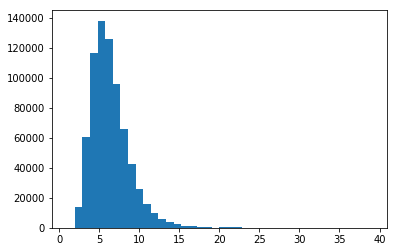

In [41]:
len_questions = []
all_chars = []
for line in questions[token]:
    question = line.split()
    len_questions.append(len(question))
    all_chars.extend(question)
all_chars = set(all_chars)
print (len(all_chars))

n,bins,patch = plt.hist(len_questions, bins=40)
plt.show()
#print (n,bins,patch)

## 构建模型

In [9]:
print('Fit the corpus...')
vec = TfidfVectorizer(
    sublinear_tf=True,
    stop_words=[],
    ngram_range=(1, 2),
    min_df=3, 
    max_df=0.9,
    use_idf=1,
    smooth_idf=1)
vec.fit(corpus)

Fit the corpus...


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=None, min_df=3,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=1,
        stop_words=[], strip_accents=None, sublinear_tf=True,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=1,
        vocabulary=None)

In [12]:
clf = RandomForestClassifier(max_depth=4, n_jobs=-1)

## 转换成特征向量

In [13]:
tfidf_train = vec.transform(train_texts[:])
tfidf_test = vec.transform(test_texts[:])

## 训练并评估

In [14]:
print('Train classifier...')
clf.fit(tfidf_train, train['label'][:])
y_pred = clf.predict_proba(tfidf_train)
print (log_loss(train['label'][:], y_pred))
cv_score = np.mean(cross_val_score(clf, tfidf_train, train['label'][:], cv=5, scoring='neg_log_loss'))
print ('Total CV score is {}'.format(-cv_score))

Train classifier...
0.6810403822134969
Total CV score is 0.6801392097690961


## 预测测试集

In [12]:
print('Predict...')
pred = clf.predict_proba(tfidf_test)
make_submission(pred[:, 1])
print('Complete!!!')

Predict...
Complete!!!
